In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
from os.path import expanduser
## actions required!!!!!!!!!!!!!!!!!!!! change your folder path 
path_repo = expanduser("~/Documents/G3_2/regime-identification"); sys.path.append(path_repo)
path_file = expanduser("~/data/G3_2/regime-identification/simulation")
path = {}
for folder in ["summary", "best-idx", "latex", "summary-cluster", "best-idx-cluster", "latex-cluster"]:
    path[folder] = f"{path_file}/{folder}"

In [2]:
import pandas as pd
import numpy as np

In [13]:
from numpy.random import RandomState
random_state = RandomState(33)

In [3]:
from regime.simulation_helper import *

In [12]:
compute_p_nbinom(extract_off_diagonal(transmat_), np.array([.1, .06]))

array([0.00021198, 0.00072709])

In [22]:
random_state.choice(2, p=[.6, .4])

1

In [4]:
def compute_p_nbinom(p_geo, n_nbinom):
    return 1 / (1 + (1 - p_geo) / (p_geo * n_nbinom))

In [38]:
class GaussianHSMM_1d_for_sample(HMM_for_sample):
    """
    a class for 1d HSMM that can sample very fastly, but can only do sampling.
    """
    def __init__(self, n_components, random_state):
        super().__init__(n_components, random_state)
        if n_components != 2:
            raise NotImplementedError()

    def _compute_p_nbinom(self):
        self.p_nbinom_ = compute_p_nbinom(extract_off_diagonal(self.transmat_), self.n_shape_)
        
    def sample_Z(self, n_samples=1, currstate=None):
        random_state = check_random_state(self.random_state)
        #
        self._compute_p_nbinom()
        Z = np.full((n_samples,), -1, dtype=np.int32)
        if currstate is None:
            startprob_cdf = np.cumsum(self.startprob_)
            currstate = (startprob_cdf > random_state.rand()).argmax()
        length = 0
        while (length < n_samples):
            nbinom_sample = random_state.negative_binomial(self.n_shape_[currstate], self.p_nbinom_[currstate]) + 1
            Z[length:max(n_samples, length+nbinom_sample)] = currstate
            length += nbinom_sample
            currstate = 1-currstate
        return Z
    
    def sample(self, n_samples=1, currstate=None):
        random_state = check_random_state(self.random_state)
        Z = self.sample_Z(n_samples, currstate)
        X = np.full((n_samples, 1), 1000.)
        for i in np.unique(Z):
            X[Z==i, :] = self.means_[i] + np.sqrt(self._covars_[i]) * random_state.randn((Z==i).sum(), 1)
        return X, Z

In [ ]:
Y=random_state.negative_binomial(n2, p2, size = (1000000,))+1

In [39]:
model=GaussianHSMM_1d_for_sample(2, random_state)

In [40]:
means_, covars_, transmat_ =load_hardy_params("daily", 2)
startprob_ = invariant_dist_transmat_(transmat_)

In [41]:
model.means_ = means_
model.covars_ = covars_
model.transmat_ = transmat_
model.startprob_ = startprob_
model.n_shape_ = np.array([.1, .06])

In [42]:
Z = model.sample_Z(1000)

In [50]:
X, Z = model.sample(100000)

In [51]:
X[Z==0, :].squeeze().mean()

0.0006126610081767648

In [52]:
X[Z==1, :].squeeze().mean()

-0.0009017499935226487

In [54]:
Z[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [11]:
model.p_binom_

array([0.00021198, 0.00072709])

In [ ]:
extract_off_diagonal()

In [6]:
transmat=res[2]

In [7]:
extract_off_diagonal(transmat)

array([0.00211576, 0.01198171])

In [ ]:
n_shape_ = np.array([.1, .06])

In [ ]:
get_HSMM_instance_for_sampling(*load_hardy_params(key_data.split("-")[-1], n_c), n_shape_=n_shape_, random_state=random_state)

In [46]:
def get_HSMM_instance_for_sampling(means_, covars_, transmat_, startprob_=None, n_shape_=None, random_state=None):
    n_c = len(transmat_)
    random_state = check_random_state(random_state)
    if startprob_ is None:
        startprob_ = invariant_dist_transmat_(transmat_)
    
    model = GaussianHSMM_1d_for_sample(n_c, random_state)
    
    model.means_ = means_
    model.covars_ = covars_
    model.transmat_ = transmat_
    model.startprob_ = startprob_
    model.n_shape_ = n_shape_
    return model

In [1]:
from scipy.stats import geom, nbinom

In [2]:
n=.1; p=.3

In [4]:
nbinom(n, p).rvs()

1

In [12]:
p=.3
print(1/p)

3.3333333333333335


In [15]:
X=random_state.geometric(p, size = (100000,))

In [16]:
X.mean()

3.33313

In [24]:
Y=random_state.negative_binomial(3, .5, size=(100000,))

In [97]:
n1 = 1; p1 = .3
n2 = 1; p2 = compute_p_nbinom(p1, n2)

In [101]:
X=random_state.geometric(p1, size = (1000000,))
Y=random_state.negative_binomial(n2, p2, size = (1000000,))+1

In [105]:
Y[:50]

array([ 2,  1,  3,  1,  3,  4,  7,  1,  4,  2,  5,  1,  5,  6,  4,  5,  2,
        3,  9,  1,  3,  1,  1,  3,  1,  1,  2,  8,  2,  1,  4,  2,  2,  1,
       10,  1,  2,  2,  4,  9,  2,  3,  8,  2,  1,  1,  1,  7,  6,  3])

In [102]:
X.mean()

3.32978

In [103]:
Y.mean()

3.338668

In [39]:
import pandas as pd

In [50]:
from scipy.stats import nbinom, geom

In [44]:
import numpy as np

In [65]:
k=np.arange(1, 200)

In [66]:
pmf1=geom(p=p1).pmf(k)

In [67]:
pmf2=nbinom(n=n2, p=p2).pmf(k-1)

In [68]:
(k*pmf1).sum()

5.000000000000003

In [69]:
((k-1)*pmf2).sum()+1

4.9999999983899865

In [72]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 30

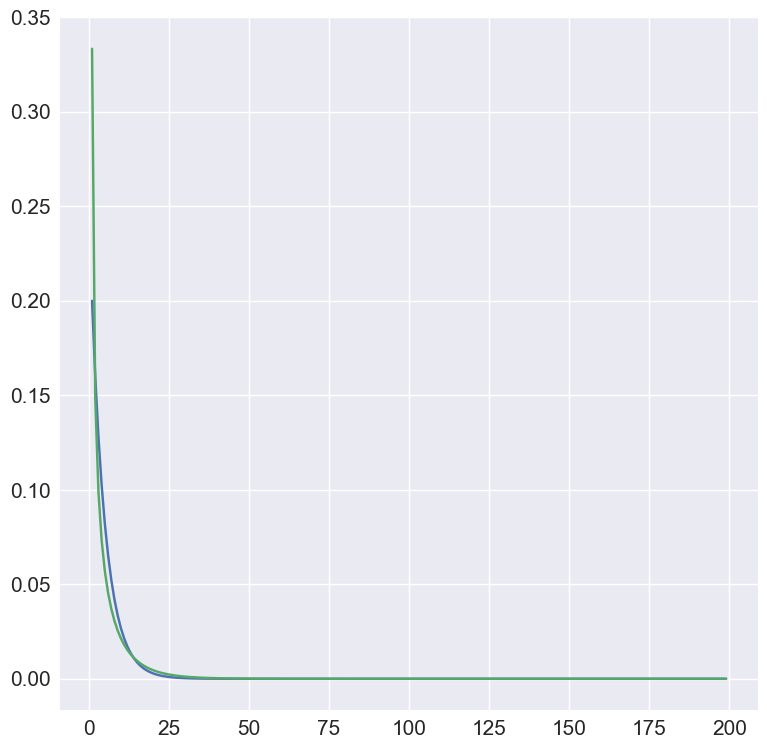

In [77]:
_, ax = plt.subplots()
ax.plot(k, pmf1)
ax.plot(k, pmf2)

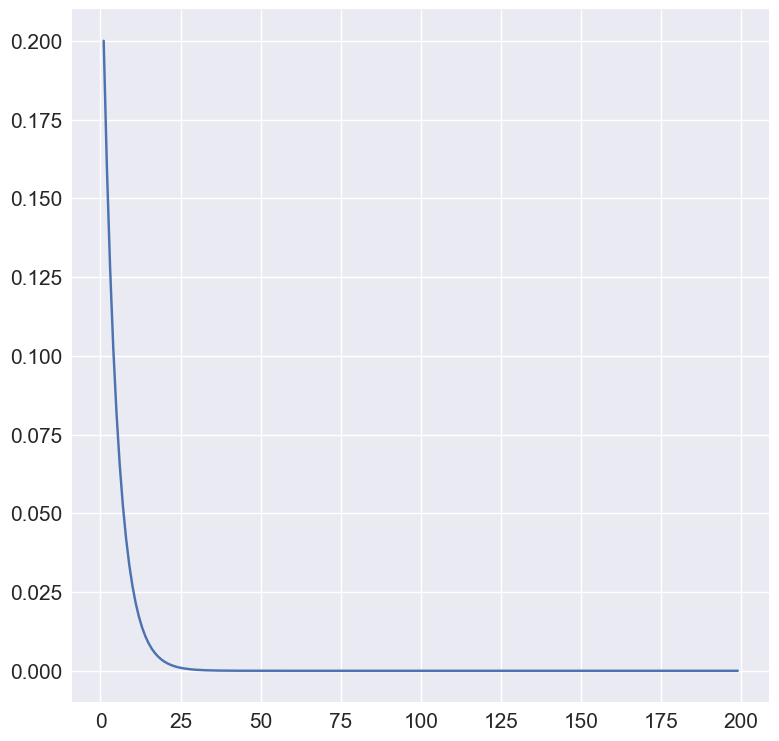

In [74]:
plt.plot(k, pmf1)

<Axes: >

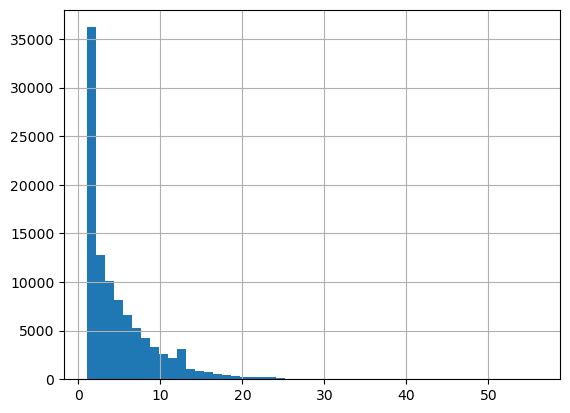

In [41]:
pd.Series(X).hist(bins=50)

<Axes: >

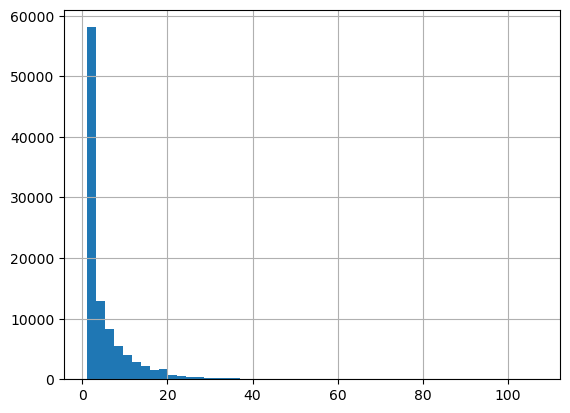

In [42]:
pd.Series(Y).hist(bins=50)

In [25]:
Y.mean()

3.00802

In [ ]:
geom().rvs()